In [1]:
# 1. SETUP & IMPORTS
!pip install -q scikit-learn matplotlib seaborn tensorflow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
import math

print("✅ TensorFlow version:", tf.__version__)


✅ TensorFlow version: 2.19.0


##  2. LOAD & EXPLORE DATASET
Uploading the file below.


In [2]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv(list(uploaded.keys())[0])
print("✅ Dataset Loaded!")
df.head(10)


Saving archive(3).zip to archive(3).zip
✅ Dataset Loaded!


,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
5,2006-04-01 05:00:00.000 +0200,Partly Cloudy,rain,9.222222,7.111111,0.85,13.9587,258.0,14.9569,0.0,1016.66,Partly cloudy throughout the day.
6,2006-04-01 06:00:00.000 +0200,Partly Cloudy,rain,7.733333,5.522222,0.95,12.3648,259.0,9.9820,0.0,1016.72,Partly cloudy throughout the day.
7,2006-04-01 07:00:00.000 +0200,Partly Cloudy,rain,8.772222,6.527778,0.89,14.1519,260.0,9.9820,0.0,1016.84,Partly cloudy throughout the day.
8,2006-04-01 08:00:00.000 +0200,Partly Cloudy,rain,10.822222,10.822222,0.82,11.3183,259.0,9.9820,0.0,1017.37,Partly cloudy throughout the day.
9,2006-04-01 09:00:00.000 +0200,Partly Cloudy,rain,13.772222,13.772222,0.72,12.5258,279.0,9.9820,0.0,1017.22,Partly cloudy throughout the day.


### 🔍 Data Exploration
- Check shape, info, and missing values
- Plot temperature trends over time


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Formatted Date            96453 non-null  datetime64[ns, UTC]
 1   Summary                   96453 non-null  object             
 2   Precip Type               96453 non-null  object             
 3   Temperature (C)           96453 non-null  float64            
 4   Apparent Temperature (C)  96453 non-null  float64            
 5   Humidity                  96453 non-null  float64            
 6   Wind Speed (km/h)         96453 non-null  float64            
 7   Wind Bearing (degrees)    96453 non-null  float64            
 8   Visibility (km)           96453 non-null  float64            
 9   Loud Cover                96453 non-null  float64            
 10  Pressure (millibars)      96453 non-null  float64            
 11  Daily Summary  

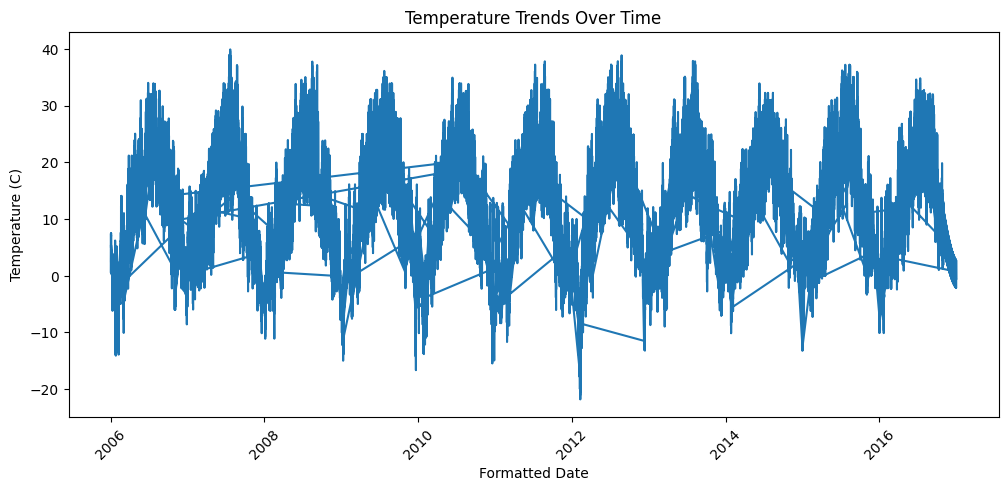

In [9]:
print(df.info())
print(df.isnull().sum())

# Plot temperature over time

df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)

plt.figure(figsize=(12, 5))
plt.plot(df['Formatted Date'], df['Temperature (C)'])
plt.xticks(rotation=45)
plt.title("Temperature Trends Over Time")
plt.xlabel("Formatted Date")
plt.ylabel("Temperature (C)")
plt.show()

## 3. DATA PREPROCESSING
- Handle missing values
- Normalize features using MinMaxScaler
- Create sequences (past 7 days → next day temperature)

In [14]:
# Fill missing values
df = df.fillna(method='ffill')

# Select relevant columns
features = ['Temperature (C)', 'Humidity', 'Wind Speed (km/h)']
target = 'Temperature (C)'

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled, columns=features)

# Create sequences
SEQ_LEN = 7
X, y = [], []
for i in range(len(scaled_df) - SEQ_LEN):
    X.append(scaled_df.iloc[i:i+SEQ_LEN].values)
    y.append(scaled_df.iloc[i+SEQ_LEN]['Temperature (C)'])

X, y = np.array(X), np.array(y)
print("X shape:", X.shape, "| y shape:", y.shape)



/tmp/ipython-input-3384385387.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


X shape: (96446, 7, 3) | y shape: (96446,)


## 4. TRAIN/VAL/TEST SPLIT


In [15]:
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

print("Train:", X_train.shape, "| Val:", X_val.shape, "| Test:", X_test.shape)


Train: (67512, 7, 3) | Val: (14466, 7, 3) | Test: (14468, 7, 3)


## 5. BUILD & TRAIN SIMPLERNN MODEL


In [16]:
model = Sequential([
    SimpleRNN(64, activation='tanh', input_shape=(SEQ_LEN, X.shape[2])),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,417 (17.25 KB)

 Trainable params: 4,417 (17.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0156 - mae: 0.0726 - val_loss: 6.3675e-04 - val_mae: 0.0194
Epoch 2/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0018 - mae: 0.0320 - val_loss: 5.2983e-04 - val_mae: 0.0162
Epoch 3/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0011 - mae: 0.0248 - val_loss: 4.1835e-04 - val_mae: 0.0140
Epoch 4/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 8.7140e-04 - mae: 0.0211 - val_loss: 4.2793e-04 - val_mae: 0.0139
Epoch 5/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 7.8767e-04 - mae: 0.0197 - val_loss: 4.1166e-04 - val_mae: 0.0140
Epoch 6/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 7.7423e-04 - mae: 0.0194 - val_loss: 4.2975e-04 - val_mae: 0.0143
Epoch 7/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 7.4489e-04 - mae: 0.0191 - val_loss: 4.1373e-04 - val_mae: 0.0142
Epoch 8/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 7.2903e-04 - mae: 0.0190 - val_loss: 4.0022e-04 -

## 6. TRAINING CURVES


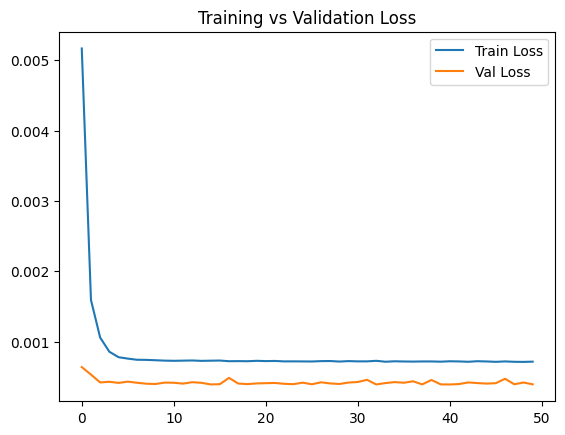

In [17]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


## 7. MODEL EVALUATION
- RMSE, MAE, R² score
- Plot predicted vs actual values


453/453 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
MAE: 0.0123 | RMSE: 0.0189 | R²: 0.9830


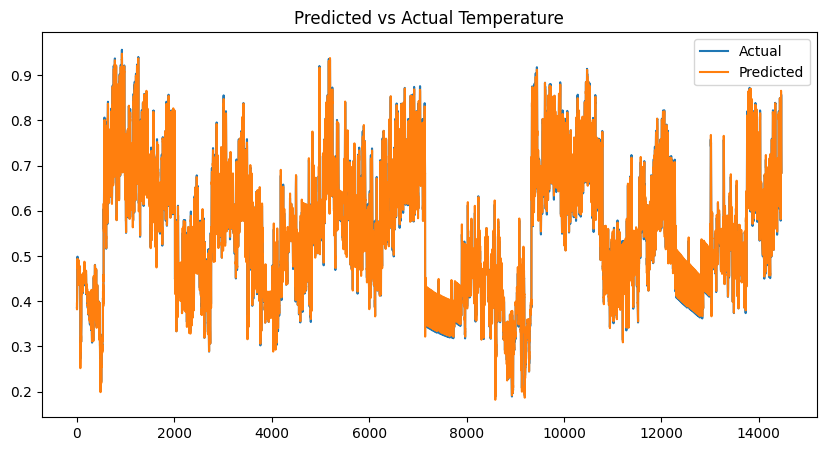

In [18]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title("Predicted vs Actual Temperature")
plt.show()


## 8. NEXT 7-DAY FORECAST
Use last 7 days of data to predict future.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


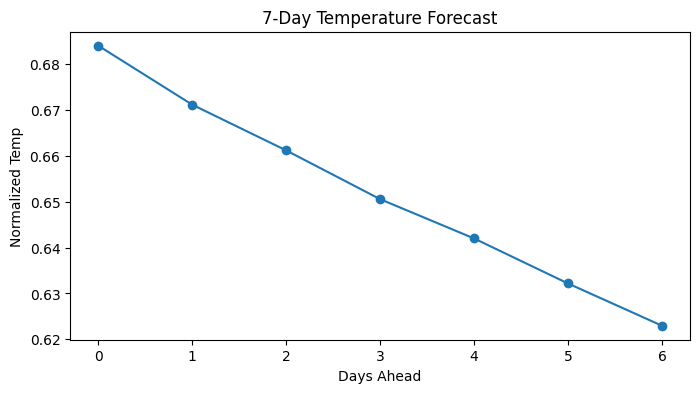

In [19]:
forecast_input = X_test[-1]  # last sequence from test set
future_preds = []

for _ in range(7):
    pred = model.predict(forecast_input.reshape(1, SEQ_LEN, X.shape[2]))
    future_preds.append(pred[0][0])
    forecast_input = np.vstack([forecast_input[1:], np.array([pred[0][0], 0.5, 0.5])])

plt.figure(figsize=(8, 4))
plt.plot(future_preds, marker='o')
plt.title("7-Day Temperature Forecast")
plt.xlabel("Days Ahead")
plt.ylabel("Normalized Temp")
plt.show()


##Conclusion:
The 7-day temperature forecast shows a consistent decreasing trend in normalized temperature over the upcoming week. Each successive day exhibits a slightly lower temperature compared to the previous day, indicating a gradual cooling pattern. This trend can help in planning for weather-sensitive activities or preparing for cooler conditions ahead.